## Implementation of SVM from scratch and comparison with KNN With K-Fold Cross Validation (Synthetic Data) 

##### Author - Sanchayan Bhunia (4849650)

#### Type-I Project -- Algorithm development

In [7]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [8]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

In [9]:
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])
    return D
    

## KNN Classifier

In [10]:
def kNNClassify(Xtr, Ytr, k, Xte, Te=1):

    n_train = Xtr.shape[0]
    n_test = Xte.shape[0]

    if any(np.abs(Ytr) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    dist = allDistances(Xte, Xtr)

    for idx in range(n_test):
        if(Te==1): # test set
            neigh_indexes = np.argsort(dist[idx, :])[:k]
        else:
            neigh_indexes = np.argsort(dist[idx, :])[1:k+1]
            
        avg_neigh = np.mean(Ytr[neigh_indexes])
        Ypred[idx] = np.sign(avg_neigh)

    return Ypred

## SVM Classifier

In [11]:
def svmPredict(Xtr, Ytr, Xte, reg_parm = 0.1, epochs = 100000):
    
    n_train, d_train = np.shape(Xtr)
    
    if any(np.abs(Ytr) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1
    
    
    
    w = np.zeros(d_train)
    
    for epoch in range(1, epochs):
        learning_rate = 1/epoch        # variable learning rate
        for i, x in enumerate(Xtr):
            if (Ytr[i] * np.dot(Xtr[i], w)) < 1:
                w = (1 - learning_rate)*w + (learning_rate)*reg_parm*Ytr[i]*Xtr[i]
            else:
                w = (1 - learning_rate)*w
    
    Ypred = np.dot(Xte, w)
    
    return Ypred, w

## Data Generation

In [12]:
def linearBinaryClass(n, low_D, high_D, m, q):

    X = np.zeros((n, 2))
    Y = np.zeros(n)
    for i in range(2):
        X[:,i] = np.random.uniform(low_D, high_D, size=n)
        
    Y[X[:,1] - (X[:,0] * m + q) > 0] = 1 
    Y[X[:,1] - (X[:,0] * m + q) < 0] = -1
    
    return X,Y

In [13]:
def flipLabels(Y, P):
    if P < 1 or P > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * P / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

# Classification Error Calculation KNN

In [14]:
def knncalcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred!=Ytrue))/len(Ytrue)

# Classification Error Calculation SVM

In [15]:
def calcErrorSVM(Ypred, Ytrue):
    cnt = 0
    for i in range(len(Ytrue)):
        if Ypred[i]*Ytrue[i] <1 :
            cnt +=1
    return cnt/len(Ytrue)

# KNN Train-Test Error Analysis

In [16]:
def knntrainTestAnalysis(Ks, Xtr, Ytr, Xte, Yte):

    train_err = np.zeros(np.shape(Ks))
    test_err = np.zeros(np.shape(Ks))

    kpos = 0
    for kpos in range(len(Ks)):
        Ypredte = kNNClassify(Xtr, Ytr, Ks[kpos], Xte)
        test_err[kpos] = knncalcError(Ypredte, Yte)
        
        Ypredtr = kNNClassify(Xtr, Ytr, Ks[kpos], Xtr)
        train_err[kpos] = knncalcError(Ypredtr, Ytr)

    return train_err, test_err

# SVM Train-Test Error Analysis

In [17]:
def svmTrainTestAnalysis(Xtr, Ytr, Xte, Yte, reg_params):
    
    train_err = np.zeros(np.shape(reg_params))
    test_err = np.zeros(np.shape(reg_params))
    
    for i in range(len(reg_params)):
        Ypredt, w_train = svmPredict(Xtr, Ytr, Xtr, reg_params[i])
        train_err[i] = calcErrorSVM(Ypredt, Ytr)
        
        Ypredtr, w_pred = svmPredict(Xtr, Ytr, Xte, reg_params[i])
        test_err[i] = calcErrorSVM(Ypredtr, Yte)

    return train_err, test_err

# K-Fold Cross Validation for KNN

In [18]:
def KFoldCVkNN(Xtr, Ytr, KF, k_list):

    if KF <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    # Ensures that k_list is a numpy array
    k_list = np.array(k_list)
    num_k = k_list.size

    n_tot = Xtr.shape[0]
    n_val = int(np.ceil(n_tot/KF))

    Tm = np.zeros(num_k)
    Ts = np.zeros(num_k)
    Vm = np.zeros(num_k)
    Vs = np.zeros(num_k)

    # Random permutation of training data
    rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
    
    
    for kdx, k in enumerate(k_list):
        first = 0
        for fold in range(KF):
           
            flags = np.zeros(Xtr.shape[0])
            flags[first:first+n_val]=1;
            
            X = Xtr[flags==0]
            Y = Ytr[flags==0]
            X_val = Xtr[flags==1]
            Y_val = Ytr[flags==1]

            # Compute the training error of the kNN classifier for the given value of k
            trError = knncalcError(kNNClassify(X, Y, k, X), Y)
            Tm[kdx] += trError
            Ts[kdx] += trError ** 2

            # Compute the validation error of the kNN classifier for the given value of k
            valError = knncalcError(kNNClassify(X, Y, k, X_val), Y_val)
            Vm[kdx] += valError
            Vs[kdx] += valError ** 2
            
            first = first+n_val                

    Tm = Tm / len(Tm)
    Ts = Ts / len(Ts) - Tm ** 2

    Vm = Vm / len(Vm)
    Vs = Vs / len(Vs) - Vm ** 2

    best_k_idx = np.argmin(Vm)
    k = k_list[best_k_idx]

    return k, Vm, Vs, Tm, Ts

# K-Fold Cross Validation for SVM

In [19]:
def kFoldCrossValidationSVM(X,Y, num_of_folds, reg_param_list):
    
    if num_of_folds <= 0 and num_of_folds >= 100 and isinstance(num_of_folds_folds, int):
        print("select an integer in between 1 and 100")
        return -1
        
    size_of_input = X.shape[0]   
    size_of_validation = int(np.ceil(size_of_input/num_of_folds))
    
    num_reg_param = len(reg_param_list)
    reg_param_list = np.array(reg_param_list)
    
    
    T_mean, T_sd, V_mean, V_sd = np.zeros(num_reg_param),                                                  \
                                 np.zeros(num_reg_param),                                                  \
                                 np.zeros(num_reg_param),                                                  \
                                 np.zeros(num_reg_param)
        
    random_index = np.random.choice(size_of_input, size=size_of_input, replace=False)
    
    for reg_index, reg_param in enumerate(reg_param_list):
        first = 0
        for fold in range(num_of_folds):
            
            flags = np.zeros(size_of_input)
            flags[first:first+size_of_validation] = 1
            
            X_training, Y_training = X[flags == 0], Y[flags == 0]
            X_validation, Y_validation = X[flags == 1], Y[flags == 1]
            
            # training Error calculation
            Y_train_predict, w = svmPredict(X_training, Y_training, X_training, reg_param)
            training_error = calcErrorSVM(Y_train_predict, Y_training)
            
            T_mean[reg_index] += training_error
            T_sd[reg_index] += training_error**2
            
            # validation errorcalculation
            Y_validation_predict, w = svmPredict(X_training, Y_training, X_validation, reg_param)
            validation_error = calcErrorSVM(Y_validation_predict, Y_validation)
            
            V_mean[reg_index] += validation_error
            V_sd[reg_index] += validation_error**2
            
            first += size_of_validation
            
    T_mean = T_mean / num_of_folds 
    T_sd = T_sd / num_of_folds - T_mean**2
    
    V_mean = V_mean / num_of_folds 
    V_sd = V_sd - V_mean**2
    
    best_reg_param_index = np.argmin(V_mean)
    best_reg_param = reg_param_list[best_reg_param_index]
    
    return best_reg_param, T_mean, T_sd, V_mean, V_sd

## Generating the data synthetically

In [20]:
X, Y = linearBinaryClass(200, 0, 20, 0.8, 0)
Y = flipLabels(Y, 5)    # 5% white noise in data

## Calling the model to get an overview for a fixed Regularization Parameter

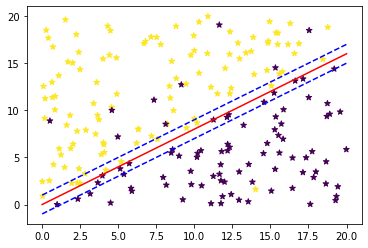

In [21]:
# % of data to be used as training
training_percentage = 70
size_of_input_data = X.shape[0]

Xtr = X[0 : (int(size_of_input_data*training_percentage/100)), :]
Ytr = Y[0: (int(size_of_input_data*training_percentage/100))]
Xte = X[(int(size_of_input_data*training_percentage/100)) : , :]
Yte = Y[(int(size_of_input_data*training_percentage/100)) : ]

reg_param = 40
Y_pred, w = svmPredict(Xtr, Ytr, Xte, reg_param) 

# Visualization of the model

plt.scatter(np.array(X[:,0]), np.array(X[:,1]),marker='*',c=Y)

# Create the hyperplane

a = -w[0] / w[1]
xx = np.linspace(0,20)
yy = a * xx 

# Plot the hyperplane
plt.plot(xx, yy, color='red')

# Plot support vectors 
plt.plot(xx, (yy+1), linestyle='--', color='blue')
plt.plot(xx, (yy-1), linestyle='--', color='blue')

plt.show();

## Let's check the trainig and validation error for Order of the Regularization Parameters

In [22]:
import timeit

reg_params = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
train_errors = np.zeros(len(reg_params))
validation_errors = np.zeros(len(reg_params))

start_time = timeit.default_timer()

train_errors, validation_errors = svmTrainTestAnalysis(Xtr, Ytr, Xte, Yte, reg_params)
    
end_time = timeit.default_timer()

print('Time taken to complete process:', end_time - start_time)

Time taken to complete process: 1036.5875281


In [23]:
print(train_errors)

[1.         1.         0.68571429 0.42857143 0.33571429 0.28571429
 0.20714286 0.08571429 0.07142857 0.06428571 0.07857143]


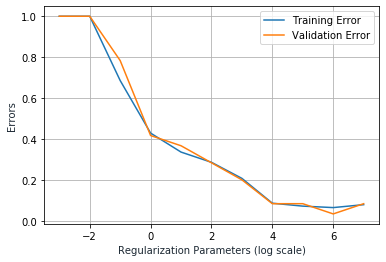

In [24]:
plt.plot(np.log10(np.array(reg_params)), np.array(train_errors), label='Training Error')
plt.plot(np.log10(np.array(reg_params)), np.array(validation_errors), label='Validation Error')
plt.xlabel('Regularization Parameters (log scale)', color='#1C2833')
plt.ylabel('Errors', color='#1C2833')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [25]:
print(validation_errors)

[1.         1.         0.78333333 0.41666667 0.36666667 0.28333333
 0.2        0.08333333 0.08333333 0.03333333 0.08333333]


## Let's run a K-Fold Cross-validation on SVM

In [80]:
reg_param_range = [10, 40, 70, 100]
number_of_folds = 3
best_reg_param, T_mean, T_sd, V_mean, V_sd = kFoldCrossValidationSVM(X,Y, number_of_folds, reg_param_range)
print(best_reg_param, V_mean, V_sd)

40 [0.05487713 0.04990201 0.04990201 0.05985225] [0.00793128 0.00600213 0.00733873 0.00891985]


# Train-Test Analysis of the dataset using KNN

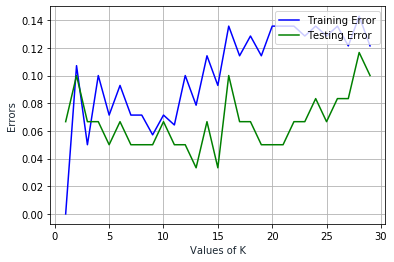

In [157]:
K  = list(range(1,30))
[training_error_knn,testing_error_knn] = knntrainTestAnalysis(K, Xtr, Ytr, Xte, Yte)
plt.plot(K, training_error_knn, 'b', label = 'Training Error')
plt.plot(K, testing_error_knn, 'g', label = 'Testing Error')
plt.xlabel('Values of K', color='#1C2833')
plt.ylabel('Errors', color='#1C2833')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# K-Fold Cross Validation for KNN on the same dataset

In [169]:
KF = 10
k_list = list(range(1, 20))
best_k, Vm_knn, Vs_knn, Tm_knn, Ts_knn = KFoldCVkNN(X, Y, KF, k_list)
print(best_k)
K = [best_k]
[training_error_knn, testing_error_knn] = knntrainTestAnalysis(K, Xtr, Ytr, Xte, Yte)
print('Validation Error for best K:', testing_error_knn)

15
Validation Error for best K: [0.03333333]


#### For this data-set the error is same (0.0333) for both SVM and KNN with theri best regularization parameter. But SVM takes a lot of time to compute w.r.t. KNN. The power of SVM comes with data with high dimension and low in number. 